In [8]:
# Data Handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [11]:
# Load all price and trade files into lists
price_files = [
    "./round-1-island-data-bottle/prices_round_1_day_-2.csv",
    "./round-1-island-data-bottle/prices_round_1_day_-1.csv",
    "./round-1-island-data-bottle/prices_round_1_day_0.csv"
]

trade_files = [
    "./round-1-island-data-bottle/trades_round_1_day_-2.csv",
    "./round-1-island-data-bottle/trades_round_1_day_-1.csv",
    "./round-1-island-data-bottle/trades_round_1_day_0.csv"
]

# Read and combine
price_data = pd.concat([pd.read_csv(file, sep=';') for file in price_files], ignore_index=True)
trade_data = pd.concat([pd.read_csv(file, sep=';') for file in trade_files], ignore_index=True)
len(price_data), len(trade_data)

(90000, 24886)

In [10]:
# Keep only SQUID_INK rows
squid_prices = price_data[price_data['product'] == 'SQUID_INK'].copy()
squid_trades = trade_data[trade_data['symbol'] == 'SQUID_INK'].copy()

# Convert timestamp to int if not already
squid_prices['timestamp'] = squid_prices['timestamp'].astype(int)
squid_trades['timestamp'] = squid_trades['timestamp'].astype(int)

# Sort by time
squid_prices.sort_values('timestamp', inplace=True)
squid_trades.sort_values('timestamp', inplace=True)

print(f"Total SQUID_INK price records: {len(squid_prices)}")
print(f"Total SQUID_INK trades: {len(squid_trades)}")


Total SQUID_INK price records: 30000
Total SQUID_INK trades: 8837


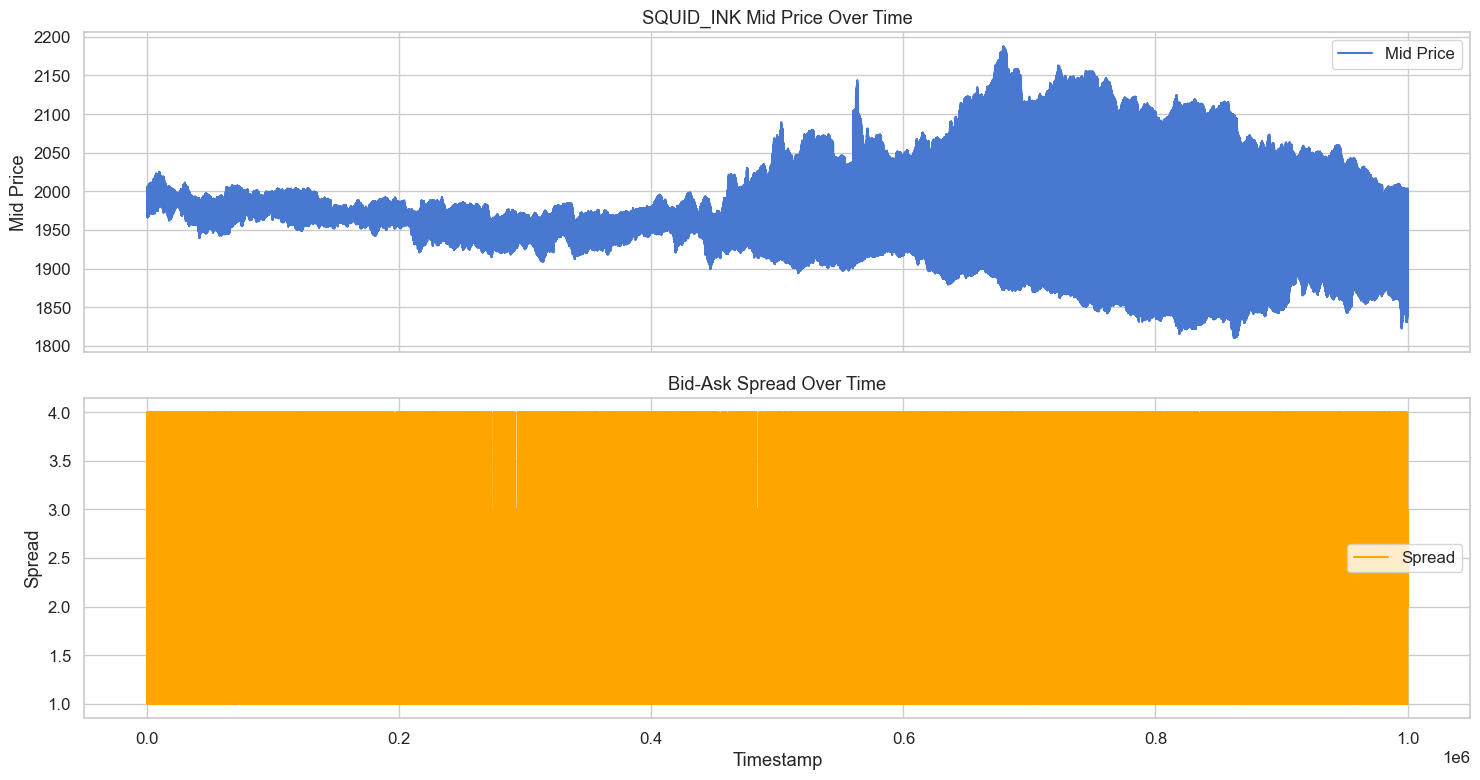

In [7]:
# Calculate spread
squid_prices['spread'] = squid_prices['ask_price_1'] - squid_prices['bid_price_1']

# Plot mid-price and spread
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
ax[0].plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price')
ax[0].set_ylabel('Mid Price')
ax[0].set_title('SQUID_INK Mid Price Over Time')
ax[0].legend()

ax[1].plot(squid_prices['timestamp'], squid_prices['spread'], color='orange', label='Spread')
ax[1].set_ylabel('Spread')
ax[1].set_title('Bid-Ask Spread Over Time')
ax[1].legend()

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()


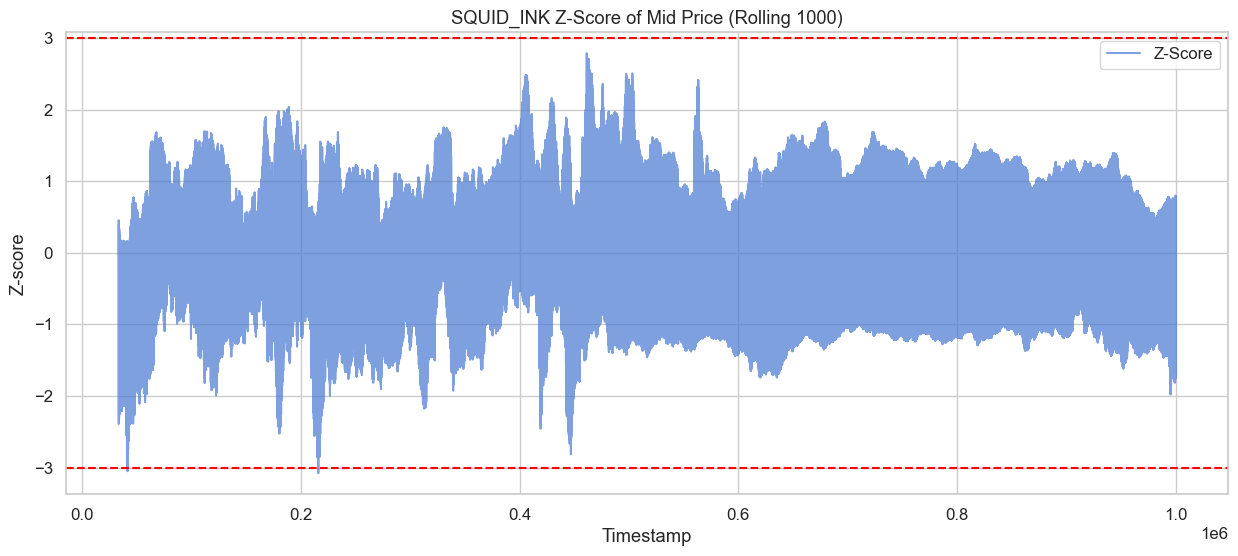

In [12]:
# Rolling metrics
WINDOW = 1000
squid_prices['rolling_mean'] = squid_prices['mid_price'].rolling(WINDOW).mean()
squid_prices['rolling_std'] = squid_prices['mid_price'].rolling(WINDOW).std()
squid_prices['z_score'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']

# Plot
plt.figure(figsize=(15, 6))
plt.plot(squid_prices['timestamp'], squid_prices['z_score'], label='Z-Score', alpha=0.7)
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.title(f'SQUID_INK Z-Score of Mid Price (Rolling {WINDOW})')
plt.ylabel('Z-score')
plt.xlabel('Timestamp')
plt.legend()
plt.show()


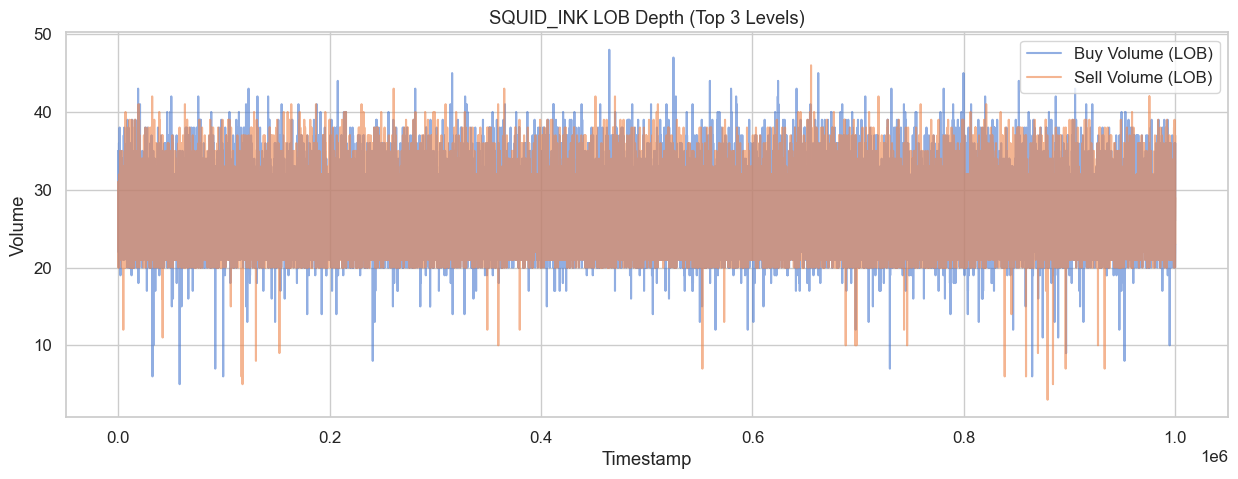

In [13]:
# Total book volume (top 3 levels)
squid_prices['buy_vol_total'] = squid_prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].sum(axis=1)
squid_prices['sell_vol_total'] = squid_prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].sum(axis=1)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(squid_prices['timestamp'], squid_prices['buy_vol_total'], label='Buy Volume (LOB)', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['sell_vol_total'], label='Sell Volume (LOB)', alpha=0.6)
plt.title('SQUID_INK LOB Depth (Top 3 Levels)')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.legend()
plt.show()


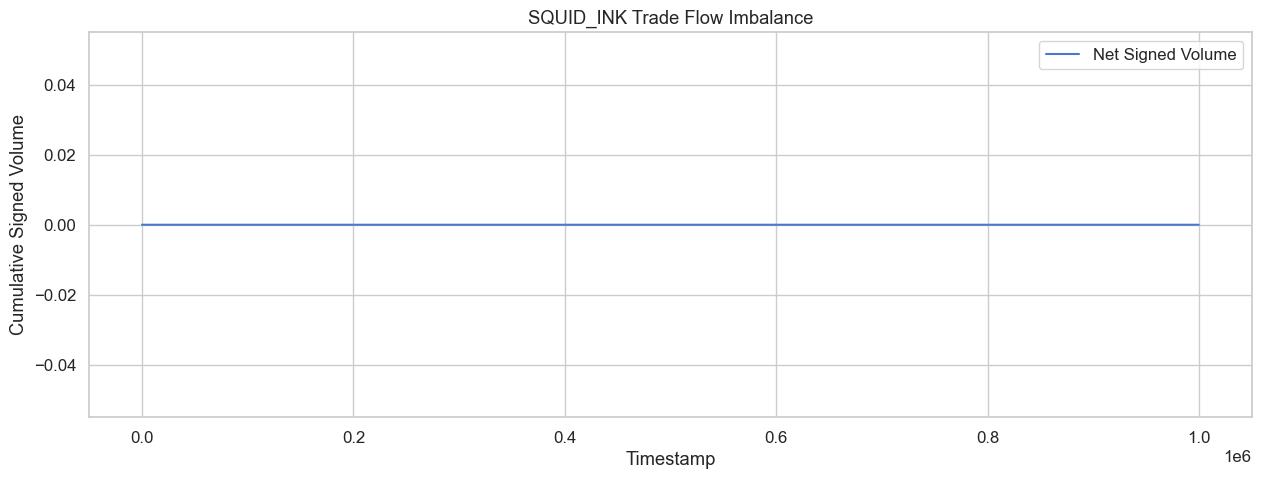

In [14]:
# Trade imbalance: positive = buy pressure, negative = sell pressure
squid_trades['signed_volume'] = np.where(squid_trades['buyer'] == 'SUBMISSION', squid_trades['quantity'],
                                         np.where(squid_trades['seller'] == 'SUBMISSION', -squid_trades['quantity'], 0))

# Cumulative flow
squid_trades['cumulative_signed_volume'] = squid_trades['signed_volume'].cumsum()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(squid_trades['timestamp'], squid_trades['cumulative_signed_volume'], label='Net Signed Volume')
plt.title('SQUID_INK Trade Flow Imbalance')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Signed Volume')
plt.legend()
plt.show()


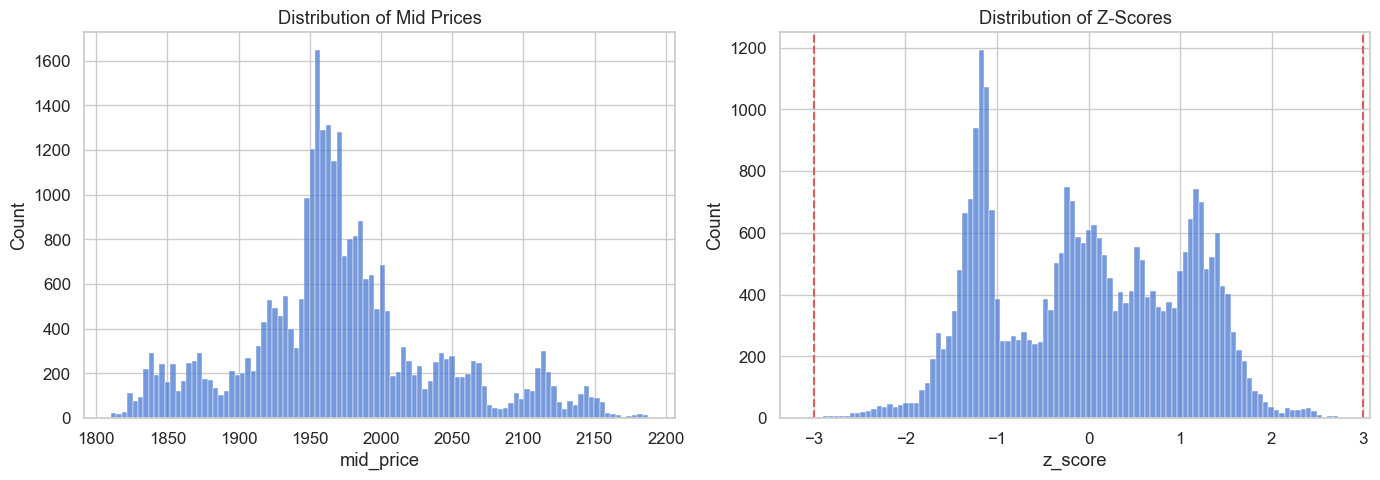

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(squid_prices['mid_price'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Mid Prices")

sns.histplot(squid_prices['z_score'].dropna(), bins=100, ax=axs[1])
axs[1].axvline(3, color='r', linestyle='--')
axs[1].axvline(-3, color='r', linestyle='--')
axs[1].set_title("Distribution of Z-Scores")

plt.tight_layout()
plt.show()
